<a href="https://colab.research.google.com/github/ThatNinjaGuy/Machine-learning-A-Z-Course/blob/develop/stock_market_strategy_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install stable-baselines3[extra]


In [33]:
import gym
import numpy as np
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from gym import spaces
import os
from stable_baselines3 import PPO
import pandas as pd
import numpy as np
import logging
from concurrent.futures import ThreadPoolExecutor

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', handlers=[
    logging.FileHandler("debug.log"),
    logging.StreamHandler()
])
logger = logging.getLogger()


from gym import spaces
import numpy as np
import pandas as pd

class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(StockTradingEnv, self).__init__()
        self.df = df.replace([np.inf, -np.inf], np.nan).dropna()  # Clean the data here
        self.current_step = 0
        self.done = False
        self.reward = 0
        self.total_reward = 0
        self.initial_cash = 10000
        self.cash = self.initial_cash
        self.holdings = 0

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Box(low=np.array([0]), high=np.array([2]), dtype=np.float16)

        # Observations
        self.observation_space = spaces.Box(
            low=0, high=np.inf, shape=(6,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.done = False
        self.reward = 0
        self.total_reward = 0
        self.cash = self.initial_cash
        self.holdings = 0
        return self._next_observation()

    def _next_observation(self):
        frame = np.array([
            self.df.iloc[self.current_step]['Close'],
            self.df.iloc[self.current_step]['Volume'],
            self.df.iloc[self.current_step]['RSI'],
            self.df.iloc[self.current_step]['MACD'],
            self.df.iloc[self.current_step]['Signal'],
            self.cash + self.holdings * self.df.iloc[self.current_step]['Close']
        ])
        if np.isnan(frame).any() or np.isinf(frame).any():
            print("Invalid observation detected: ", frame)
            raise ValueError("Invalid observation detected")
        print("Observation: ", frame)
        return frame

    def step(self, action):
        self.current_step += 1

        if self.current_step >= len(self.df) - 1:
            self.done = True

        self._take_action(action)

        reward = self.cash + self.holdings * self.df.iloc[self.current_step]['Close'] - self.initial_cash
        self.reward = reward
        self.total_reward += reward

        obs = self._next_observation()

        # Debugging step
        print(f'Step: {self.current_step}, Action: {action}, Reward: {reward}, Cash: {self.cash}, Holdings: {self.holdings}')

        return obs, reward, self.done, {}

    def _take_action(self, action):
        current_price = self.df.iloc[self.current_step]['Close']
        action_type = action if np.isscalar(action) else action[0]

        if action_type < 1:  # Buy
            num_shares_to_buy = self.cash // current_price
            if np.isnan(num_shares_to_buy) or np.isinf(num_shares_to_buy):
                raise ValueError("Invalid action resulting in NaN or Inf number of shares to buy")
            self.cash -= num_shares_to_buy * current_price
            self.holdings += num_shares_to_buy
        elif action_type >= 1:  # Sell
            self.cash += self.holdings * current_price
            self.holdings = 0

    def render(self, mode='human', close=False):
        profit = self.cash + self.holdings * self.df.iloc[self.current_step]['Close'] - self.initial_cash
        print(f'Step: {self.current_step}')
        print(f'Cash: {self.cash}')
        print(f'Holdings: {self.holdings}')
        print(f'Profit: {profit}')


In [34]:
def _next_observation(self):
    frame = np.array([
        self.df.iloc[self.current_step]['Close'],
        self.df.iloc[self.current_step]['Volume'],
        self.df.iloc[self.current_step]['RSI'],
        self.df.iloc[self.current_step]['MACD'],
        self.df.iloc[self.current_step]['Signal'],
        self.cash + self.holdings * self.df.iloc[self.current_step]['Close']
    ])
    if np.isnan(frame).any() or np.isinf(frame).any():
        print("Invalid observation detected: ", frame)
        raise ValueError("Invalid observation detected")
    print("Observation: ", frame)
    return frame


In [35]:
# Function to train the RL agent
import torch

def train_rl_agent(df):
    # Initialize the environment and model
    env = DummyVecEnv([lambda: StockTradingEnv(df.copy())])
    model = PPO('MlpPolicy', env, verbose=1)

    # Train the model
    model.learn(total_timesteps=20000)

    return model

# Function to get time periods for backtesting
def get_time_periods(data, period_years):
    periods = []
    start_date = data.index.min()
    end_date = data.index.max()
    current_start = start_date

    while current_start < end_date:
        current_end = current_start + pd.DateOffset(years=period_years)
        if current_end > end_date:
            current_end = end_date
        periods.append((current_start, current_end))
        current_start = current_end + pd.DateOffset(days=1)

    return periods

def visualize_rl_strategy(data):
    rl_portfolio_col = 'Portfolio_RL'
    if rl_portfolio_col in data.columns:
        plot_strategy_performance(data, rl_portfolio_col, 'Reinforcement Learning Strategy')
    else:
        logger.warning(f"{rl_portfolio_col} column not found in the DataFrame.")


# Function to load the data
def load_data(file_path):
    data = pd.read_csv(file_path, parse_dates=['Timestamp'], index_col='Timestamp')
    data.columns = data.columns.str.strip()  # Clean up column names
    return data

# Function to resample data
def resample_data(data):
    data = data[~data.index.duplicated(keep='first')]
    return data.resample('D').ffill()

# Function to add computed values
def add_computed_values(data, ma_windows):
    for window in ma_windows:
        data[f'MA{window}'] = data['Close'].rolling(window=window).mean()
    data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
    data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    data['RSI'] = 100 - (100 / (1 + data['Close'].pct_change().rolling(window=14).apply(lambda x: (x[x > 0].sum() / abs(x[x < 0].sum())))))
    return data

# Plot functions
def plot_resampled_data(resampled_data):
    fig, ax = plt.subplots(figsize=(12, 6))
    resampled_data['Close'].plot(ax=ax, title='Stock Prices (Close) - Resampled to 30-Minute Intervals', ylabel='Price')
    plt.show()

def calculate_moving_average(data, window):
    return data['Close'].rolling(window=window).mean()

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def plot_moving_averages(data, ma_windows):
    fig, axes = plt.subplots(len(ma_windows), 1, figsize=(12, 4 * len(ma_windows)), sharex=True)

    if len(ma_windows) == 1:
        axes = [axes]

    for i, window in enumerate(ma_windows):
        ma = calculate_moving_average(data, window)
        data['Close'].plot(ax=axes[i], label='Close Price', color='blue')
        ma.plot(ax=axes[i], label=f'MA{window}', color='orange')
        axes[i].set_title(f'Moving Average (MA{window})')
        axes[i].set_ylabel(f'MA{window}')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def plot_macd(macd, signal):
    fig, ax = plt.subplots(figsize=(12, 6))
    macd.plot(ax=ax, label='MACD', color='b')
    signal.plot(ax=ax, label='Signal Line', color='r')
    ax.set_title('MACD')
    ax.legend()
    plt.show()

def plot_rsi(rsi):
    fig, ax = plt.subplots(figsize=(12, 6))
    rsi.plot(ax=ax, label='RSI', color='g')
    ax.axhline(30, linestyle='--', alpha=0.5, color='r')
    ax.axhline(70, linestyle='--', alpha=0.5, color='r')
    ax.set_title('RSI')
    ax.legend()
    plt.show()

def plot_volume(data):
    fig, ax = plt.subplots(figsize=(12, 6))
    data['Volume'].plot(ax=ax, title='Trading Volumes', ylabel='Volume')
    plt.show()

import firebase_admin
from firebase_admin import credentials, db

# Function to initialize Firebase app
def initialize_firebase():
    if not firebase_admin._apps:
        cred = credentials.Certificate('/content/stockmarket-b9c19-firebase-adminsdk-uqexr-f4be4c7249.json')
        firebase_admin.initialize_app(cred, {
            'databaseURL': 'https://stockmarket-b9c19-default-rtdb.firebaseio.com/'
        })

# Function to upload data to firebase in chunks
def upload_data_to_firebase(data, stock_name):
    # Initialize Firebase app if not already initialized
    initialize_firebase()

    # Reference to the Firebase database
    ref = db.reference('stocks/' + stock_name)

    # Reset the index and convert timestamps to strings
    data.reset_index(inplace=True)  # Reset the index to ensure it's unique
    data['Timestamp'] = data['Timestamp'].astype(str)  # Convert Timestamps to strings

    # Replace out-of-range float values with None
    data = data.replace({float('inf'): None, float('-inf'): None, float('nan'): None})

    # Convert the dataframe to a dictionary
    data_dict = df_to_dict(data)

    # Upload data in chunks
    batch_size = 500  # Adjust batch size as needed
    # for i in range(0, len(data_dict), batch_size):
    #     chunk = dict(list(data_dict.items())[i:i + batch_size])
    #     ref.update(chunk)

    print("Data uploaded to Firebase successfully.")

# Function to convert dataframe to dictionary
def df_to_dict(df):
    return df.to_dict(orient='index')

def rsi_strategy(data, lower_threshold=30, upper_threshold=70):
    data = data.copy()
    data['Signal_RSI'] = 0
    data.loc[data['RSI'] < lower_threshold, 'Signal_RSI'] = 1  # Buy signal
    data.loc[data['RSI'] > upper_threshold, 'Signal_RSI'] = -1  # Sell signal
    data['Position_RSI'] = data['Signal_RSI'].shift()
    return data

def moving_average_signal(data, window):
    signal_col = f'Signal_MA{window}'
    position_col = f'Position_MA{window}'

    data[signal_col] = 'UNINVESTED'
    valid_ma = data[f'MA{window}'].notna()

    # Define buy and sell conditions
    buy_condition = (data['Close'].shift(1) > data[f'MA{window}'].shift(1)) & (data['Close'] <= data[f'MA{window}']) & valid_ma
    sell_condition = (data['Close'].shift(1) < data[f'MA{window}'].shift(1)) & (data['Close'] >= data[f'MA{window}']) & valid_ma

    invested = False

    for i in range(len(data)):
        if i < 2600:
            continue  # Skip the first 2600 records (200 days * 13 data points per day)
        if pd.isna(data['Close'].iloc[i]) or data['Close'].iloc[i] == 0:
            continue  # Skip if Close price is NaN or 0
        if not invested and buy_condition.iloc[i]:
            data.at[data.index[i], signal_col] = 'BUY'
            invested = True
        elif invested and sell_condition.iloc[i]:
            data.at[data.index[i], signal_col] = 'SELL'
            invested = False
        elif invested:
            data.at[data.index[i], signal_col] = 'ALREADY INVESTED'

    data[position_col] = data[signal_col].apply(lambda x: 1 if x == 'BUY' else -1 if x == 'SELL' else 0)
    data[position_col] = data[position_col].diff()

    return data

def moving_average_signal(data, window):
    data[f'Signal_MA{window}'] = 0
    data[f'Position_MA{window}'] = 0
    data[f'Signal_MA{window}'] = np.where(data['Close'] > data[f'MA{window}'], 1, -1)
    data[f'Position_MA{window}'] = data[f'Signal_MA{window}'].shift()
    return data

def load_and_preprocess_data(file_path, ma_windows):
    data = load_data(file_path)
    resampled_data = resample_data(data)
    plot_resampled_data(resampled_data)
    data_with_values = add_computed_values(data, ma_windows)
    data_with_values.sort_index(inplace=True)
    return data_with_values

def plot_indicators(data_with_values, ma_windows):
    plot_moving_averages(data_with_values, ma_windows)
    plot_macd(data_with_values['MACD'], data_with_values['Signal'])
    plot_rsi(data_with_values['RSI'])
    plot_volume(data_with_values)

In [36]:
def save_and_upload_data(data, stock_name):
    output_file_path = '/content/' + stock_name + '_with_strategies.csv'
    data.to_csv(output_file_path, index=False)
    print(f"Data with strategies saved to {output_file_path}")
    upload_data_to_firebase(data, stock_name)


In [37]:
def remove_duplicate_timestamps(data):
    duplicated = data.index.duplicated(keep='first')
    if duplicated.any():
        print("Removing duplicate timestamps...")
        data = data[~duplicated]
    return data

def adjust_duplicate_timestamps(data):
    from pandas.tseries.offsets import Milli
    if data.index.has_duplicates:
        print("Adjusting duplicate timestamps...")
        for dup in data.index[data.index.duplicated()].unique():
            duplicates = data.index.get_loc(dup)
            for i in range(len(duplicates)):
                data.index.values[duplicates[i]] += Milli(i)
    return data


In [38]:
import pickle

def save_intermediate_data(data, filename):
    with open(filename, 'wb') as file:
        pickle.dump(data, file)
    print(f"Data saved to {filename}")

def load_intermediate_data(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    print(f"Data loaded from {filename}")
    return data


In [39]:
import matplotlib.pyplot as plt

def visualize_rl_strategy(data):
    rl_portfolio_col = 'Portfolio_RL'
    if rl_portfolio_col in data.columns:
        plot_strategy_performance(data, rl_portfolio_col, 'Reinforcement Learning Strategy')
    else:
        logger.warning(f"{rl_portfolio_col} column not found in the DataFrame.")

def plot_strategy_performance(data, portfolio_col, strategy_name):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data[portfolio_col], label=portfolio_col)
    plt.title(strategy_name)
    plt.legend()
    plt.show()

def visualize_all_strategies(data, ma_windows):
    for window in ma_windows:
        strategy_col = f'Portfolio_MA{window}'
        if strategy_col in data.columns:
            plot_strategy_performance(data, strategy_col, f'Moving Average {window} Strategy')
    if 'Portfolio_RSI' in data.columns:
        plot_strategy_performance(data, 'Portfolio_RSI', 'RSI Strategy')
    if 'Portfolio_RL' in data.columns:
        plot_strategy_performance(data, 'Portfolio_RL', 'Reinforcement Learning Strategy')


In [40]:
def clean_data(df):
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    return df

def ensure_unique_index(df):
    """Ensure the DataFrame index is unique by removing duplicates."""
    df = df[~df.index.duplicated(keep='first')]
    return df

def process_period(window, start, end, data):
    start_idx = data.index.searchsorted(start)
    end_idx = data.index.searchsorted(end)
    period_data = data.iloc[start_idx:end_idx + 1]

    print(f'Data Index Type: {type(data.index)}')
    data_with_strategy = moving_average_signal(period_data.copy(), window)
    data_with_strategy, total_gain = backtest_strategy(
        data_with_strategy, f'Signal_MA{window}', f'Portfolio_MA{window}', initial_cash=10000
    )
    print(f'Total gain from MA{window} strategy: ${total_gain:.2f}')
    return window, period_data.index, data_with_strategy[f'Portfolio_MA{window}']

def ensure_unique_index(df):
    """Ensure the DataFrame index is unique by removing duplicates."""
    df = df[~df.index.duplicated(keep='first')]
    return df

def train_and_backtest_rl_agent(data, periods):
    model_filename = '/content/rl_model'

    # Check if the model already exists
    if os.path.exists(model_filename + ".zip"):
        # Load the model
        rl_model = PPO.load(model_filename)
        print("Loaded RL model from disk.")
    else:
        print("Training Reinforcement Learning Agent...")
        rl_model = train_rl_agent(data)
        # Save the model
        rl_model.save(model_filename)
        print("Trained and saved RL model to disk.")

    print("Generating RL signals...")
    signals_df = generate_rl_signals(data, rl_model)
    data['RL_Signal'] = signals_df['RL_Signal']

    print("Backtesting RL Strategy...")
    for start, end in periods:
        if start not in data.index:
            print(f"Adjusting start timestamp {start}...")
            start = data.index.asof(start)
        if end not in data.index:
            print(f"Adjusting end timestamp {end}...")
            end = data.index.asof(end)

        start_idx = data.index.searchsorted(start)
        end_idx = data.index.searchsorted(end)
        period_data = data.iloc[start_idx:end_idx + 1]

        data_with_rl_strategy, total_gain_rl = backtest_strategy(period_data.copy(), 'RL_Signal', 'Portfolio_RL', initial_cash=10000, start=start, end=end)
        print(f'Total gain from RL strategy: ${total_gain_rl:.2f}')
        data.loc[period_data.index, 'Portfolio_RL'] = data_with_rl_strategy['Portfolio_RL']

    return data

def backtest_strategy(data, signal_col, portfolio_col, initial_cash, start, end):
    cash = initial_cash
    holdings = 0
    portfolio_value = []

    start_idx, end_idx = data.index.get_loc(start), data.index.get_loc(end)
    period_data = data.iloc[start_idx:end_idx + 1].copy()  # Ensure a deep copy

    print(f"Backtesting from {start} to {end}...")

    for index, row in period_data.iterrows():
        signal = row[signal_col]
        close_price = row['Close']
        print(f"Step: {index}, Signal: {signal}, Close Price: {close_price}, Cash: {cash}, Holdings: {holdings}")
        if signal == 1:  # Buy signal
            if cash >= close_price:  # Check if there's enough cash to buy
                holdings += cash // close_price
                cash %= close_price
                print(f"  Bought: New Cash: {cash}, New Holdings: {holdings}")
        elif signal == -1:  # Sell signal
            cash += holdings * close_price
            holdings = 0
            print(f"  Sold: New Cash: {cash}, New Holdings: {holdings}")
        portfolio_value.append(cash + holdings * close_price)

    period_data.loc[:, portfolio_col] = portfolio_value  # Use .loc to avoid SettingWithCopyWarning
    total_gain = portfolio_value[-1] - initial_cash
    print(f"Total gain: ${total_gain:.2f}")
    return period_data, total_gain

def backtest_moving_average_strategies(data, ma_windows, periods):
    data = data[~data.index.duplicated(keep='first')]

    for window in ma_windows:
        for start, end in periods:
            if start not in data.index:
                start = data.index.asof(start)
            if end not in data.index:
                end = data.index.asof(end)

            period_data = data.loc[start:end]
            data_with_strategy = moving_average_signal(data.copy(), window)
            data_with_strategy, total_gain = backtest_strategy(
                data_with_strategy, f'Signal_MA{window}', f'Portfolio_MA{window}', initial_cash=10000, start=start, end=end
            )
            print(f'Total gain from Close Price and MA{window} strategy: ${total_gain:.2f}')

            suffix = f'_MA{window}'
            all_columns = [f'Signal_MA{window}', f'Position_MA{window}', f'Portfolio_MA{window}']
            new_columns = [col + suffix for col in all_columns]
            data_with_strategy.rename(columns=dict(zip(all_columns, new_columns)), inplace=True)

            columns_to_join = [col for col in new_columns if col not in data.columns]
            data = data.join(data_with_strategy[columns_to_join],how='left')
    return data

def backtest_rsi_strategy(data, periods):
    data = data[~data.index.duplicated(keep='first')]

    for start, end in periods:
        if start not in data.index:
            start = data.index.asof(start)
        if end not in data.index:
            end = data.index.asof(end)

        period_data = data.loc[start:end]
        data_with_strategy = rsi_strategy(period_data.copy(), 30, 70)
        data_with_strategy, total_gain_rsi = backtest_strategy(data_with_strategy, 'Signal_RSI', 'Portfolio_RSI', initial_cash=10000, start=start, end=end)
        print(f'Total gain from RSI strategy: ${total_gain_rsi:.2f}')

        suffix = '_RSI'
        all_columns = ['Signal_RSI', 'Position_RSI', 'Portfolio_RSI']
        new_columns = [col + suffix for col in all_columns]
        data_with_strategy.rename(columns=dict(zip(all_columns, new_columns)), inplace=True)

        columns_to_join = [col for col in new_columns if col not in data.columns]
        data = data.join(data_with_strategy[columns_to_join], how='left')
    return data

def visualize_all_strategies(data, ma_windows):
    for window in ma_windows:
        strategy_col = f'Portfolio_MA{window}_MA{window}'
        if strategy_col in data.columns:
            plot_strategy_performance(data, strategy_col, f'Moving Average {window} Strategy')
    if 'Portfolio_RSI_RSI' in data.columns:
        plot_strategy_performance(data, 'Portfolio_RSI_RSI', 'RSI Strategy')
    if 'Portfolio_RL' in data.columns:
        plot_strategy_performance(data, 'Portfolio_RL', 'Reinforcement Learning Strategy')

def visualize_rl_strategy(data):
    rl_portfolio_col = 'Portfolio_RL'
    if rl_portfolio_col in data.columns:
        plot_strategy_performance(data, rl_portfolio_col, 'Reinforcement Learning Strategy')
    else:
        logger.warning(f"{rl_portfolio_col} column not found in the DataFrame.")

def plot_strategy_performance(data, portfolio_col, strategy_name):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data[portfolio_col], label=portfolio_col)
    plt.title(strategy_name)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.show()


In [41]:
def generate_rl_signals(data, model):
    env = StockTradingEnv(data)
    obs = env.reset()
    signals = []

    for _ in range(len(data)):
        action, _states = model.predict(obs)
        action_type = action if np.isscalar(action) else action[0]
        signal = 0  # Default to hold
        if action_type < 1:
            signal = 1  # Buy
        elif action_type >= 1:
            signal = -1  # Sell
        obs, reward, done, info = env.step(action)
        signals.append(signal)
        if done:
            obs = env.reset()

    # Ensure signals length matches data length
    while len(signals) < len(data):
        signals.append(signals[-1])
    signals = signals[:len(data)]

    signals_df = pd.DataFrame(signals, index=data.index, columns=['RL_Signal'])
    print("RL Signals Generated:")
    print(signals_df.head())
    return signals_df


def train_and_backtest_rl_agent(data, periods):
    model_filename = '/content/rl_model'

    # Check if the model already exists
    if os.path.exists(model_filename + ".zip"):
        # Load the model
        rl_model = PPO.load(model_filename)
        logger.info("Loaded RL model from disk.")
    else:
        logger.info("Training Reinforcement Learning Agent...")
        rl_model = train_rl_agent(data)
        # Save the model
        rl_model.save(model_filename)
        logger.info("Trained and saved RL model to disk.")

    logger.info("Generating RL signals...")
    signals_df = generate_rl_signals(data, rl_model)
    data['RL_Signal'] = signals_df['RL_Signal']

    logger.info("Backtesting RL Strategy...")
    for start, end in periods:
        if start not in data.index:
            logger.info(f"Adjusting start timestamp {start}...")
            start = data.index.asof(start)
        if end not in data.index:
            logger.info(f"Adjusting end timestamp {end}...")
            end = data.index.asof(end)

        start_idx = data.index.searchsorted(start)
        end_idx = data.index.searchsorted(end)
        period_data = data.iloc[start_idx:end_idx + 1]

        data_with_rl_strategy, total_gain_rl = backtest_strategy(period_data.copy(), 'RL_Signal', 'Portfolio_RL', initial_cash=10000, start=start, end=end)
        logger.info(f'Total gain from RL strategy: ${total_gain_rl:.2f}')
        data.loc[period_data.index, 'Portfolio_RL'] = data_with_rl_strategy['Portfolio_RL']

    print("Backtested RL Strategy:")
    print(data[['RL_Signal', 'Portfolio_RL']].tail())  # Display last few rows
    return data


In [42]:
from scipy.optimize import newton
import numpy as np

def xirr(cash_flows):
    def npv(rate):
        return sum([cf / (1 + rate) ** ((date - cash_flows[0][0]).days / 365.0) for date, cf in cash_flows])

    try:
        return newton(npv, 0)
    except RuntimeError as e:
        print(f"XIRR calculation failed to converge: {e}")
        return np.nan

def calculate_strategy_metrics(data, strategy_col, initial_cash):
    # Filter out NaN values
    valid_data = data.dropna(subset=[strategy_col])

    # If there are no valid data points, return NaN for all metrics
    if valid_data.empty:
        return np.nan, np.nan, np.nan

    final_value = valid_data[strategy_col].iloc[-1]
    total_days = (valid_data.index[-1] - valid_data.index[0]).days
    years = total_days / 365.0

    # XIRR calculation assumes initial investment at the start and final portfolio value at the end
    cash_flows = [(valid_data.index[0], -initial_cash), (valid_data.index[-1], final_value)]
    print(f"Cash Flows for XIRR: {cash_flows}")

    xirr_value = xirr(cash_flows)
    cagr_value = cagr(initial_cash, final_value, years)

    return final_value, xirr_value, cagr_value


def print_strategy_metrics(data, strategies, initial_cash):
    for strategy_name, strategy_col in strategies.items():
        final_value, xirr_value, cagr_value = calculate_strategy_metrics(data, strategy_col, initial_cash)
        print(f"Strategy: {strategy_name}")
        print(f"  Final Portfolio Value: ${final_value:,.2f}")
        if not np.isnan(xirr_value):
            print(f"  XIRR: {xirr_value:.2%}")
        else:
            print("  XIRR: Calculation failed to converge")
        print(f"  CAGR: {cagr_value:.2%}\n")


In [45]:
def setup_initial_data(file_path, ma_windows):
    """Loads, cleans, and prepares the initial data."""
    data = load_data(file_path)
    data = clean_data(data)
    data = ensure_unique_index(data)
    resampled_data = resample_data(data)
    data_with_values = add_computed_values(data, ma_windows)
    data_with_values.sort_index(inplace=True)
    return data_with_values, resampled_data

def backtest_all_strategies(data, ma_windows, periods):
    """Backtests all strategies and returns the modified data."""
    data = backtest_moving_average_strategies(data, ma_windows, periods)
    data = backtest_rsi_strategy(data, periods)
    data = train_and_backtest_rl_agent(data, periods)
    return data

def plot_all(data_with_values, resampled_data, ma_windows, all_strategies_data):
    """Handles all plotting activities."""
    plot_resampled_data(resampled_data)
    plot_moving_averages(data_with_values, ma_windows)
    plot_macd(data_with_values['MACD'], data_with_values['Signal'])
    plot_rsi(data_with_values['RSI'])
    plot_volume(data_with_values)
    visualize_all_strategies(all_strategies_data, ma_windows)
    visualize_rl_strategy(all_strategies_data)


Streaming output truncated to the last 5000 lines.
Step: 2022-12-09 11:45:00+05:30, Signal: 1, Close Price: 3650.55, Cash: 2128.2499999999927, Holdings: 6.0
Step: 2022-12-09 12:15:00+05:30, Signal: 1, Close Price: 3624.05, Cash: 2128.2499999999927, Holdings: 6.0
Step: 2022-12-09 12:45:00+05:30, Signal: 1, Close Price: 3636.15, Cash: 2128.2499999999927, Holdings: 6.0
Step: 2022-12-09 13:15:00+05:30, Signal: 1, Close Price: 3631.65, Cash: 2128.2499999999927, Holdings: 6.0
Step: 2022-12-09 13:45:00+05:30, Signal: 1, Close Price: 3628.9, Cash: 2128.2499999999927, Holdings: 6.0
Step: 2022-12-09 14:15:00+05:30, Signal: 1, Close Price: 3629.05, Cash: 2128.2499999999927, Holdings: 6.0
Step: 2022-12-09 14:45:00+05:30, Signal: 1, Close Price: 3618.75, Cash: 2128.2499999999927, Holdings: 6.0
Step: 2022-12-09 15:15:00+05:30, Signal: 1, Close Price: 3617.0, Cash: 2128.2499999999927, Holdings: 6.0
Step: 2022-12-12 09:15:00+05:30, Signal: 0, Close Price: 3650.45, Cash: 2128.2499999999927, Holdings: 6

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Streaming output truncated to the last 5000 lines.
  Bought: New Cash: 1262.5999999998003, New Holdings: 108.0
Step: 2023-02-03 09:45:00+05:30, Signal: 1, Close Price: 1622.35, Cash: 1262.5999999998003, Holdings: 108.0
Step: 2023-02-03 10:15:00+05:30, Signal: 1, Close Price: 1622.35, Cash: 1262.5999999998003, Holdings: 108.0
Step: 2023-02-03 10:45:00+05:30, Signal: 1, Close Price: 1622.35, Cash: 1262.5999999998003, Holdings: 108.0
Step: 2023-02-03 11:15:00+05:30, Signal: 1, Close Price: 1622.35, Cash: 1262.5999999998003, Holdings: 108.0
Step: 2023-02-03 11:45:00+05:30, Signal: 1, Close Price: 1622.35, Cash: 1262.5999999998003, Holdings: 108.0
Step: 2023-02-03 12:15:00+05:30, Signal: 1, Close Price: 1622.35, Cash: 1262.5999999998003, Holdings: 108.0
Step: 2023-02-03 12:45:00+05:30, Signal: 1, Close Price: 1622.35, Cash: 1262.5999999998003, Holdings: 108.0
Step: 2023-02-03 13:15:00+05:30, Signal: 1, Close Price: 1622.35, Cash: 1262.5999999998003, Holdings: 108.0
Step: 2023-02-03 13:45:00

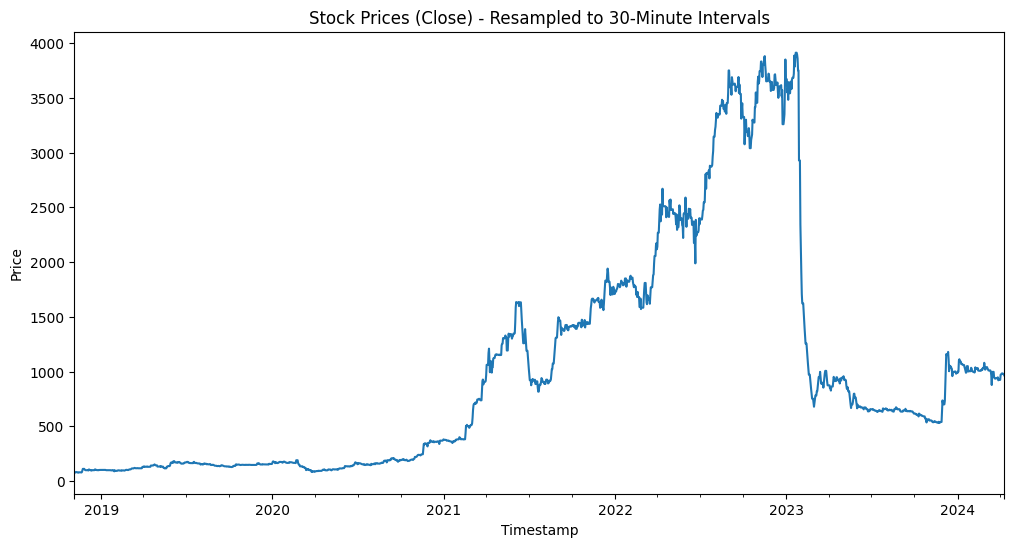

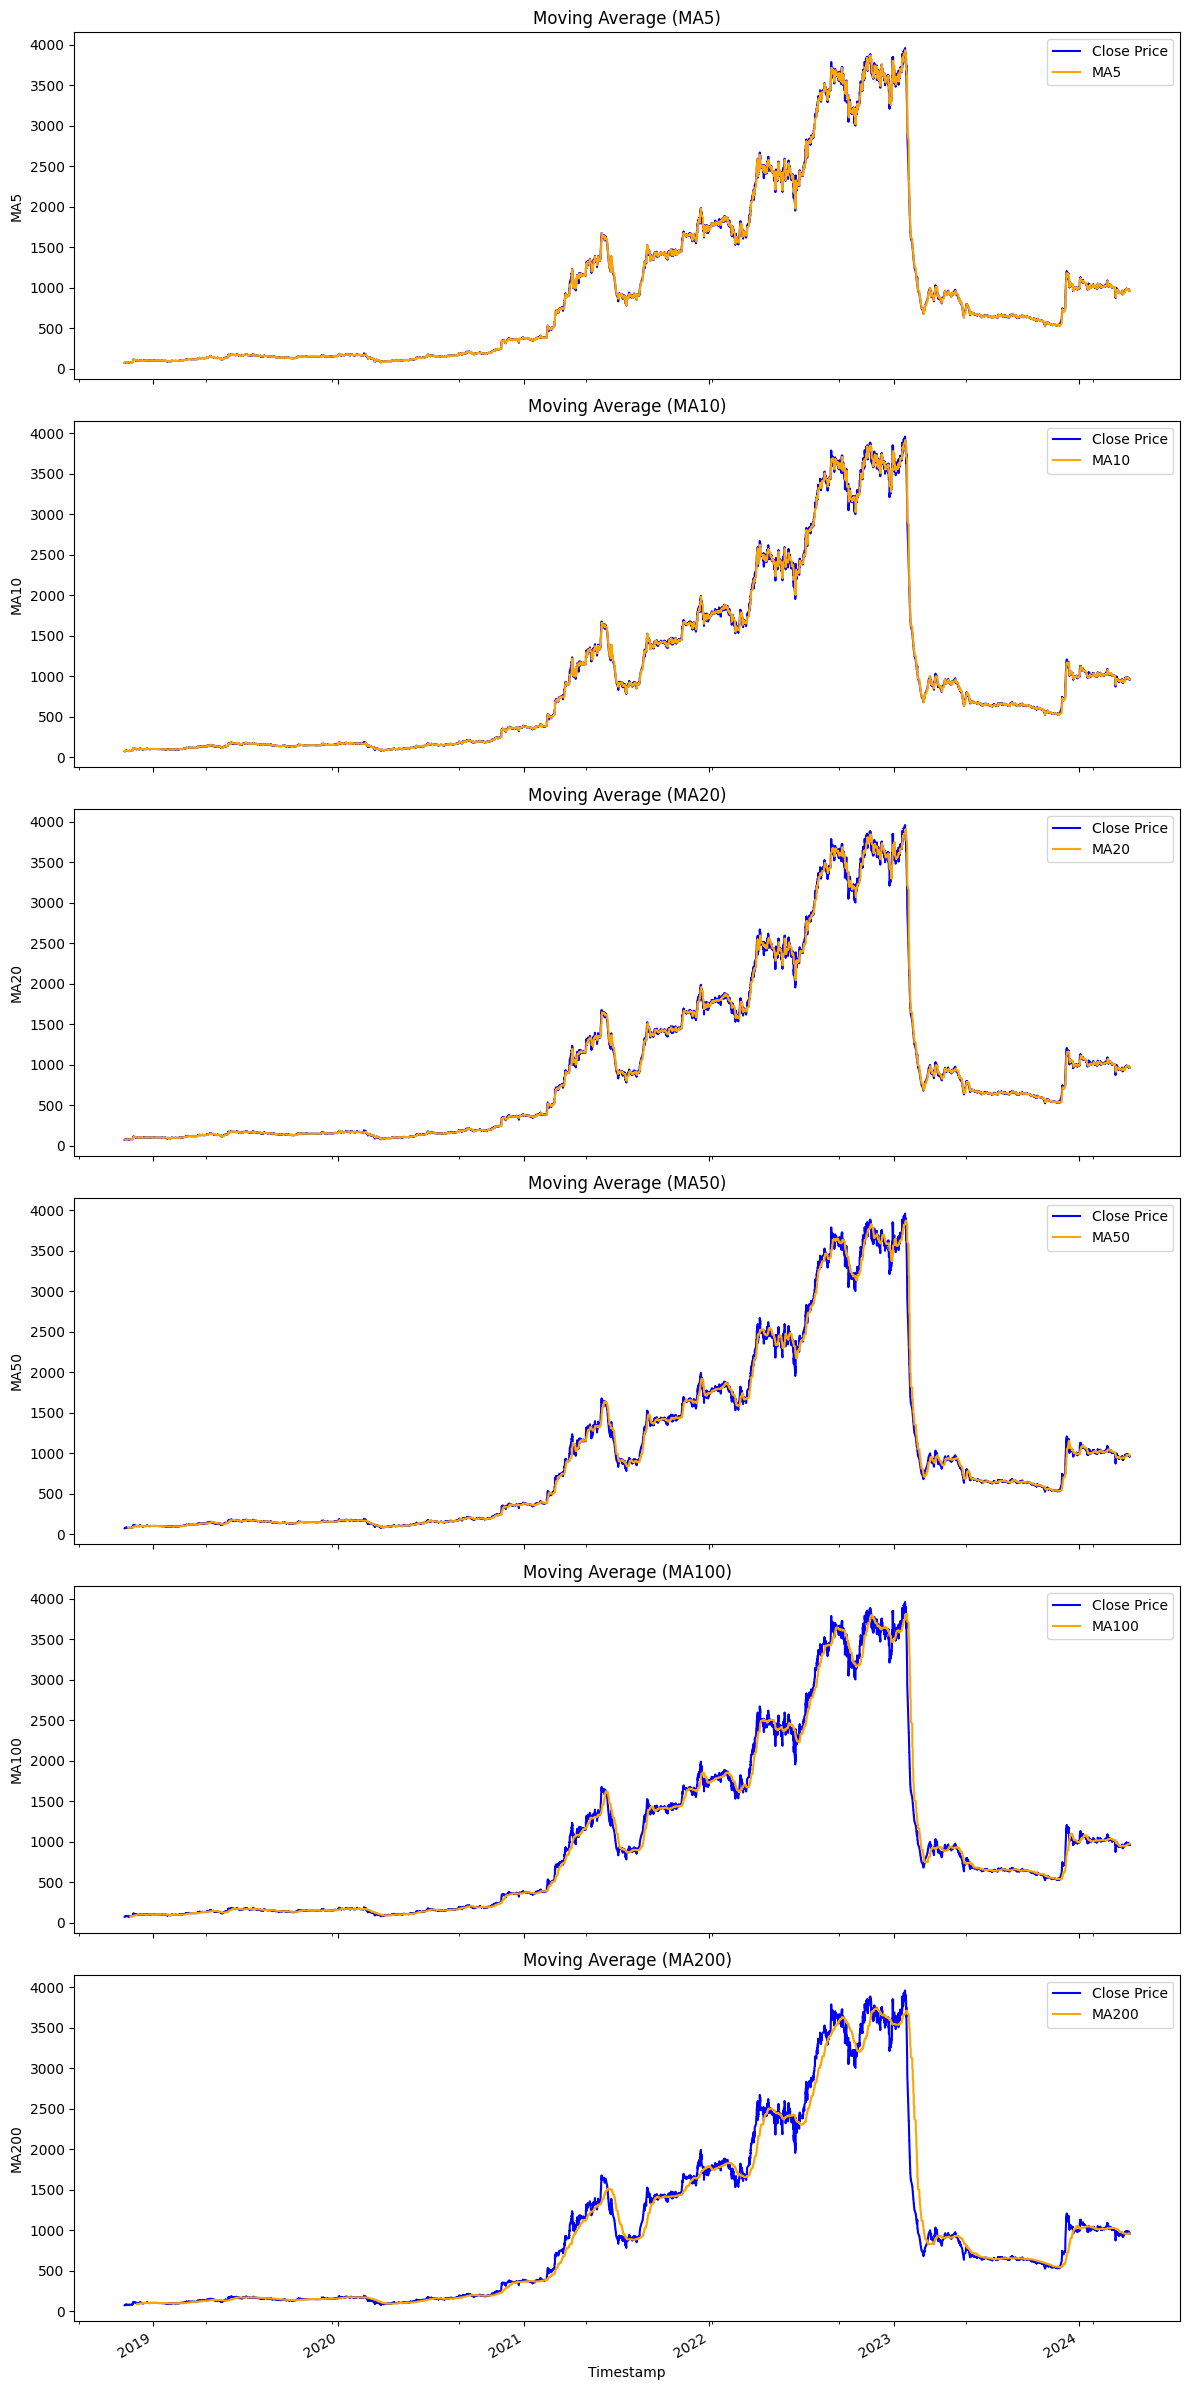

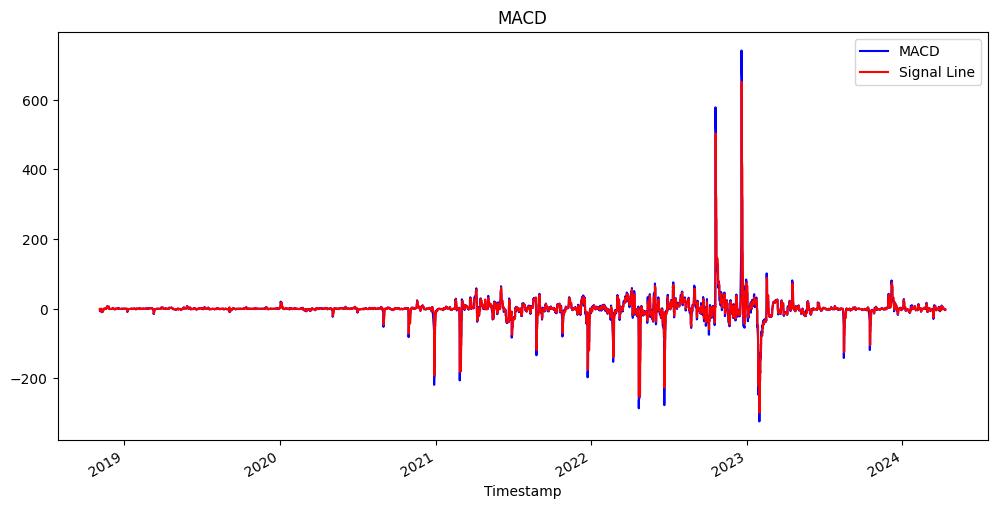

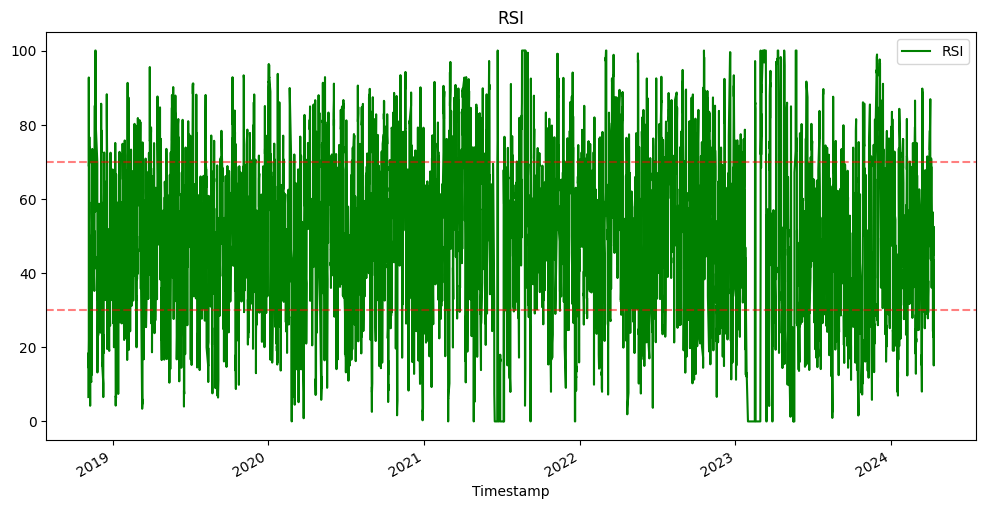

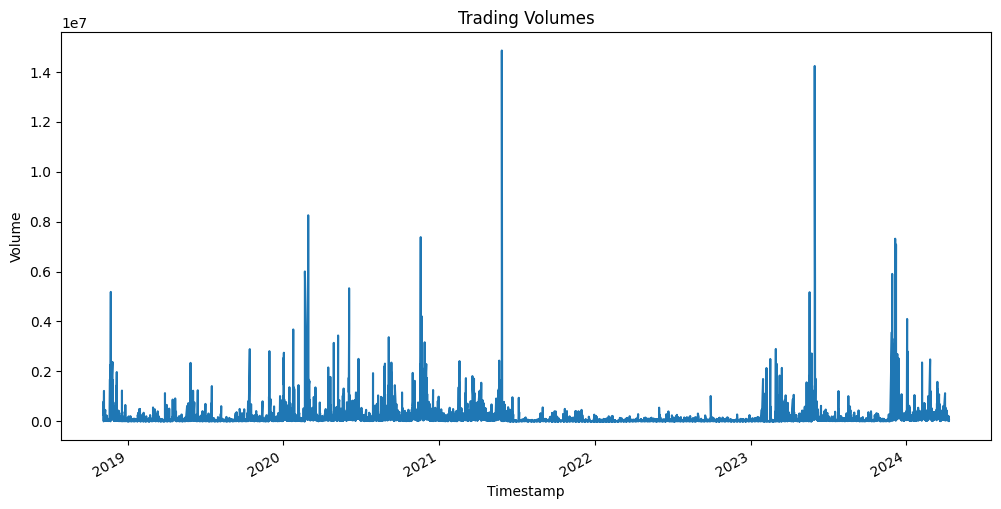

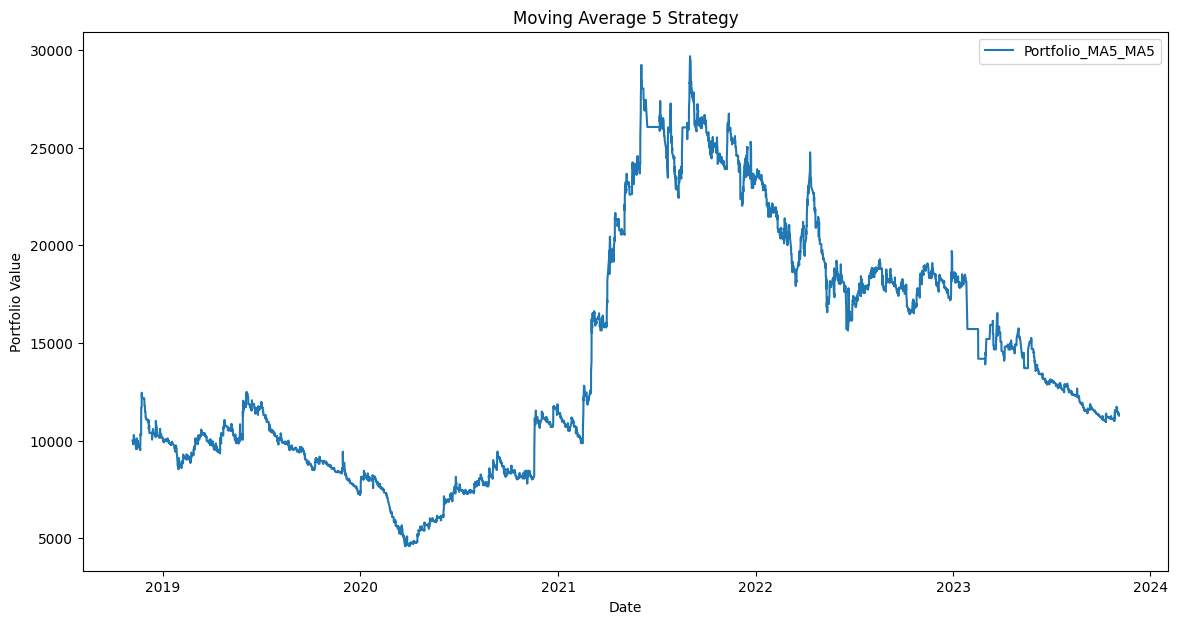

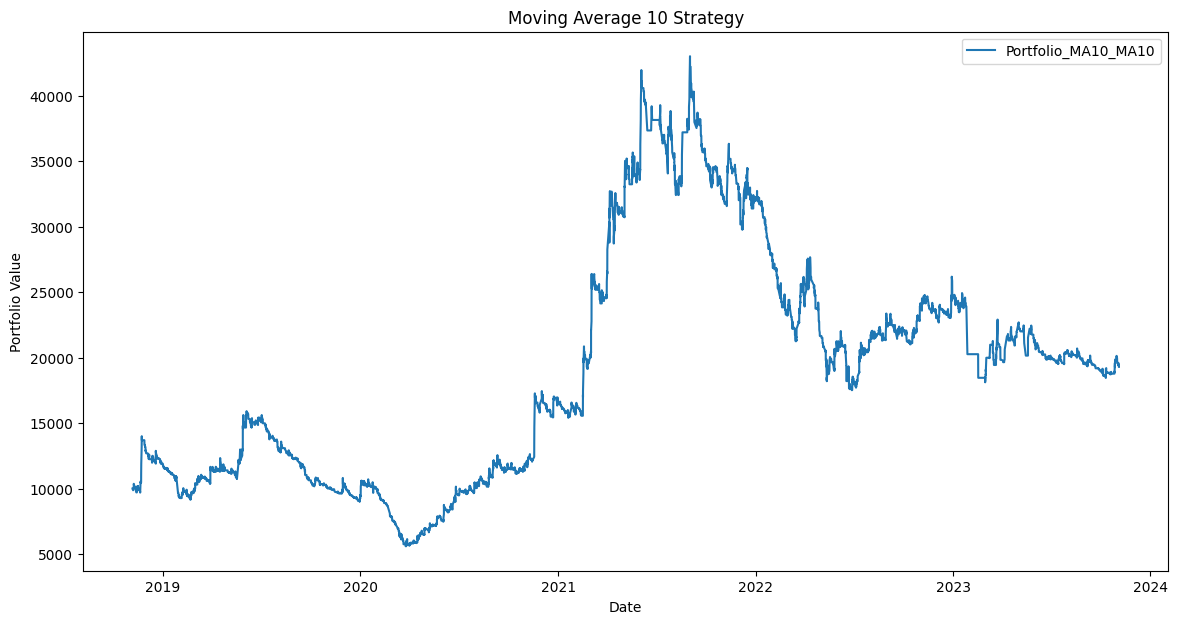

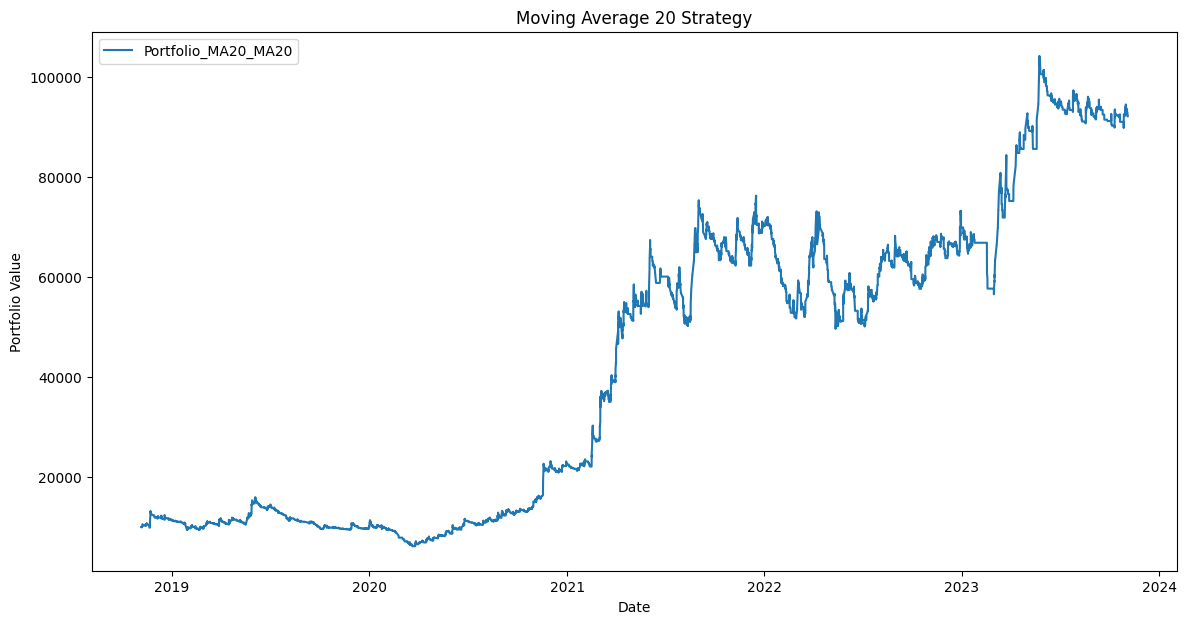

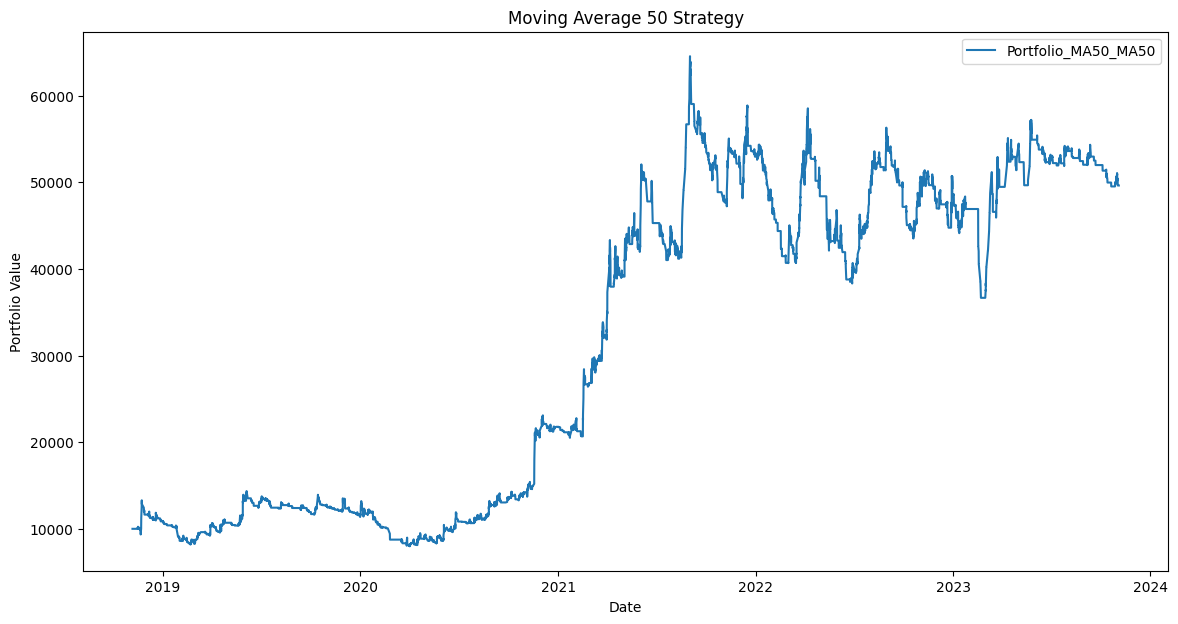

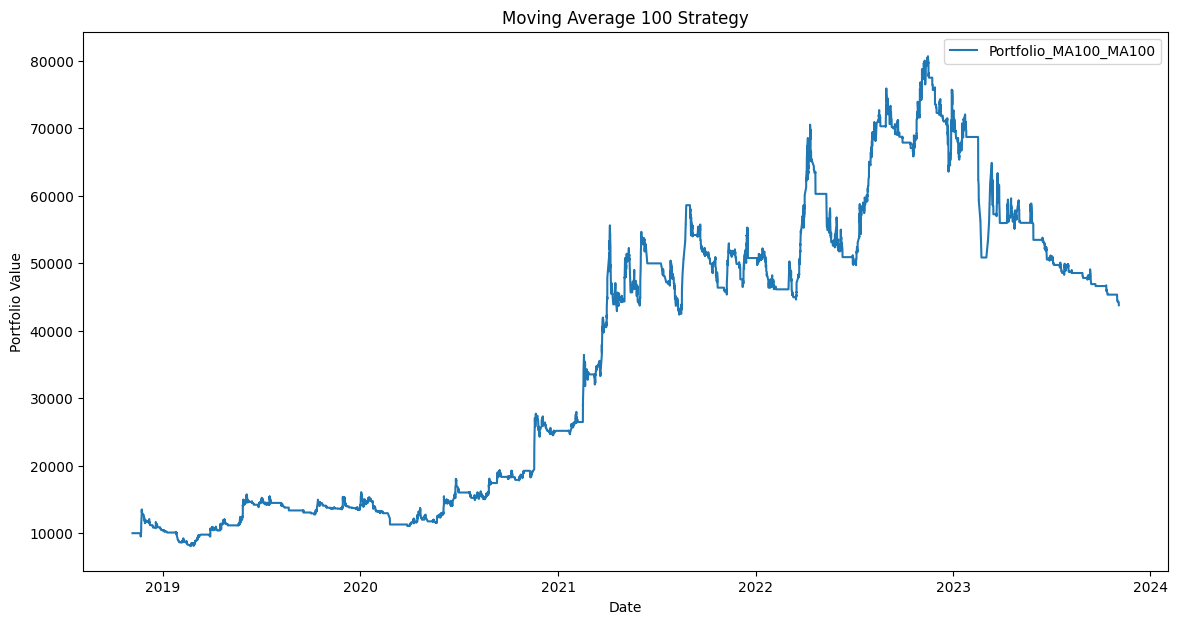

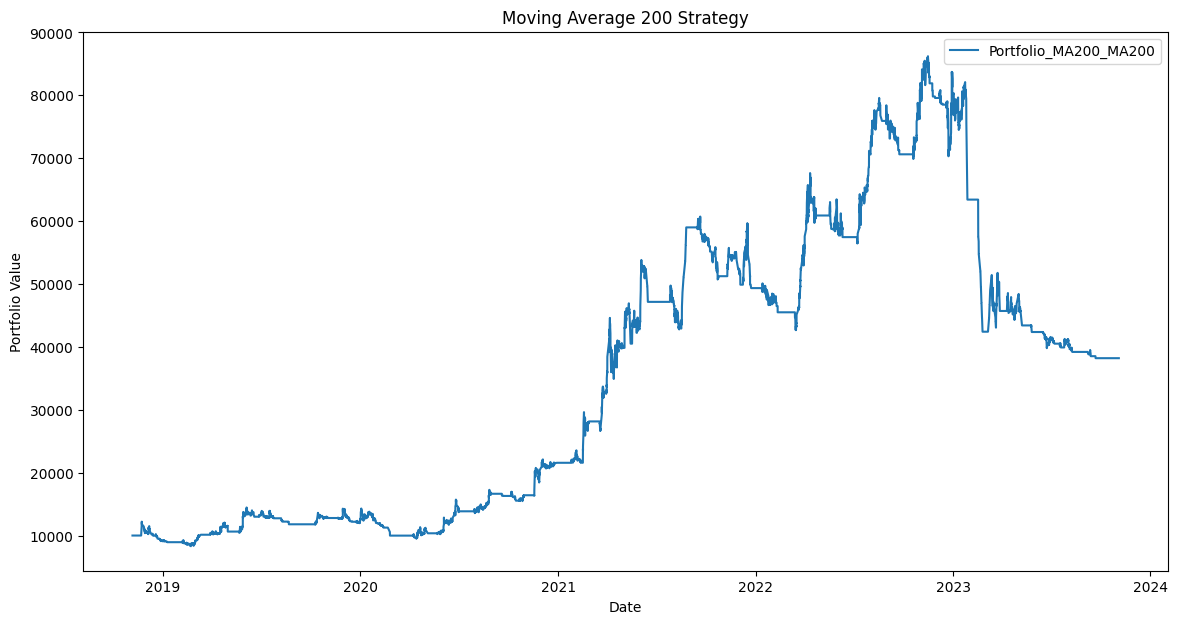

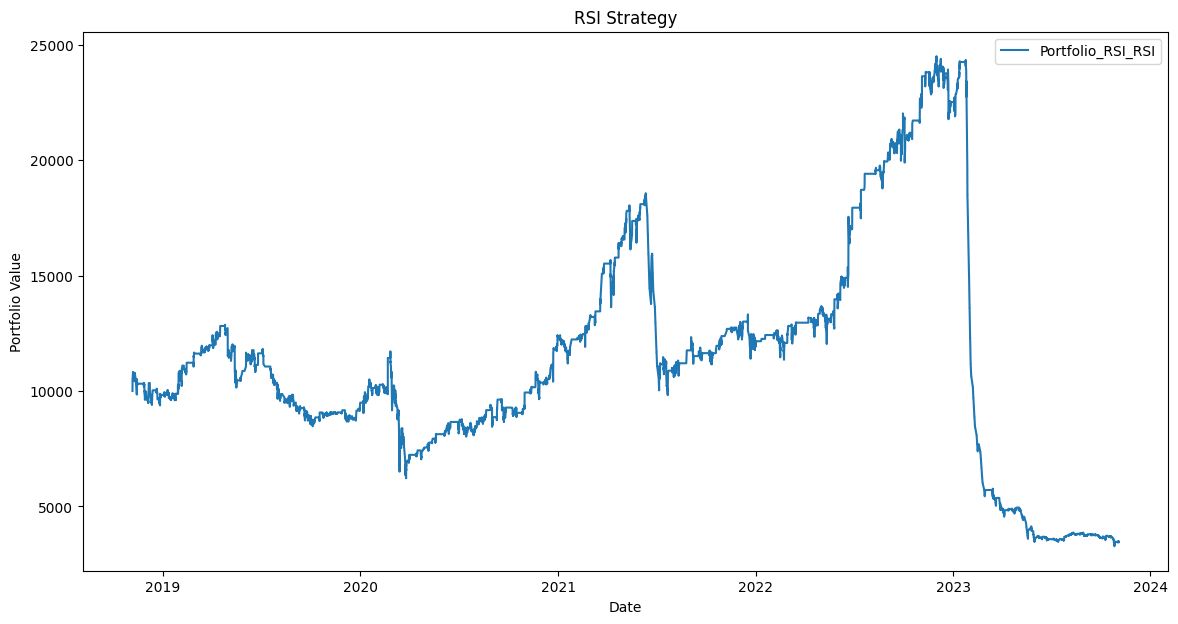

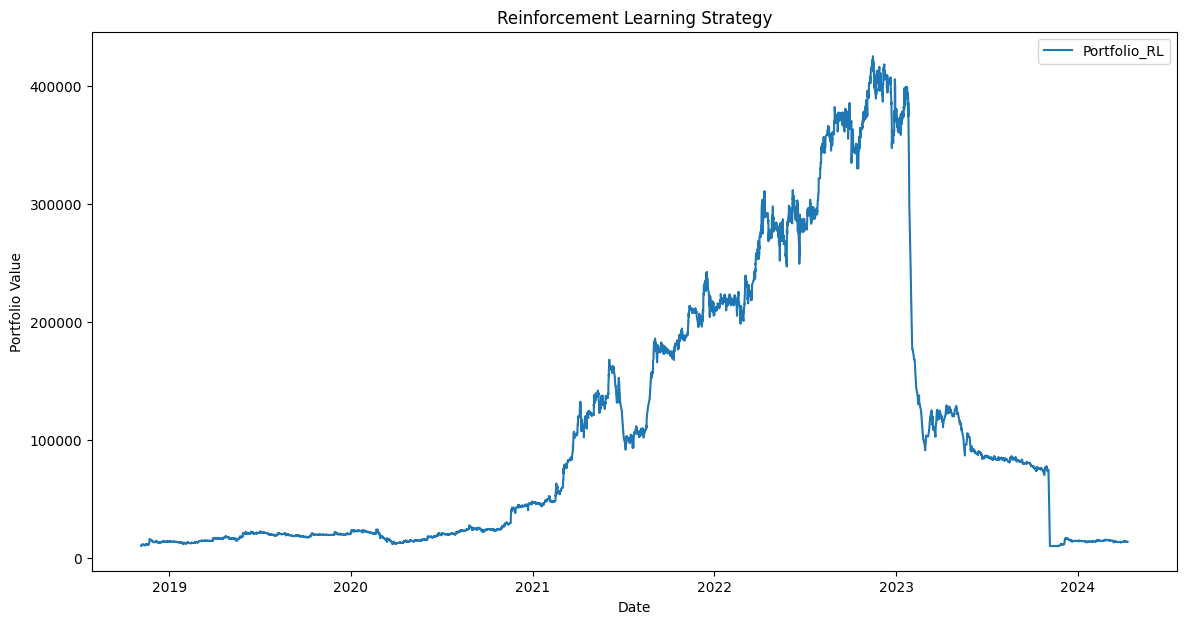

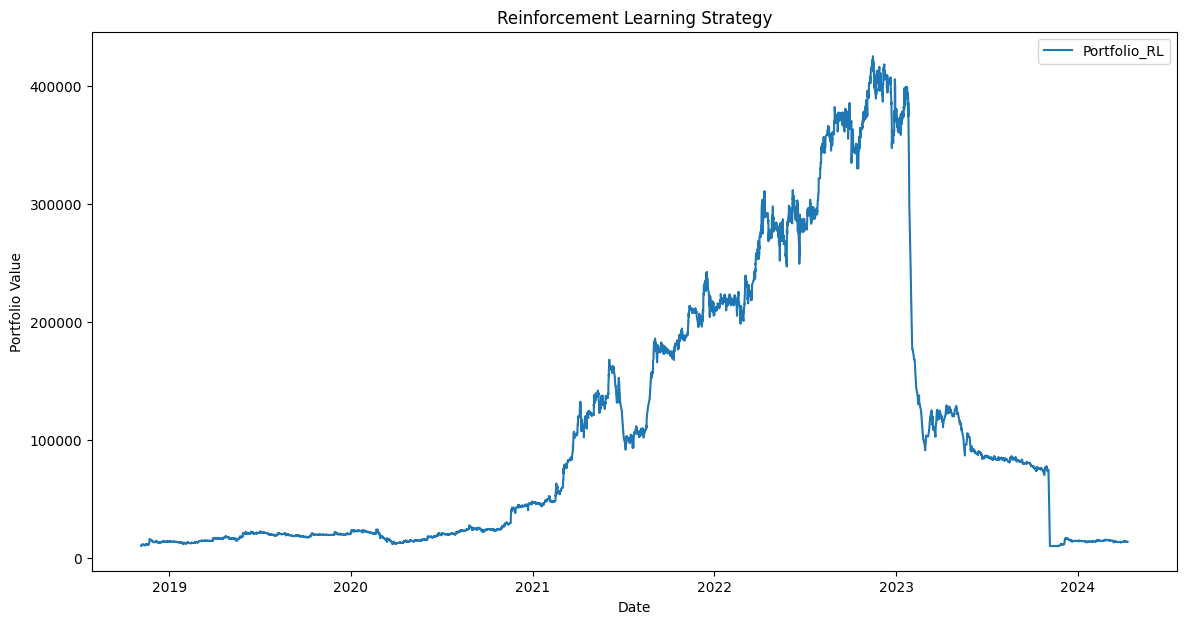

Data with strategies saved to /content/ADANI_TOTAL_GAS_with_strategies.csv
Data uploaded to Firebase successfully.


In [43]:
def main():
    stock_name = 'ADANI_TOTAL_GAS'
    file_path = f'/content/{stock_name}.csv'
    output_file_path = f'/content/{stock_name}_with_strategies.csv'
    ma_windows = [5, 10, 20, 50, 100, 200]
    initial_cash = 10000

    data_with_values, resampled_data = setup_initial_data(file_path, ma_windows)
    all_strategies_data = data_with_values.copy()
    periods = get_time_periods(all_strategies_data, 5)

    all_strategies_data = backtest_all_strategies(all_strategies_data, ma_windows, periods)

    strategies = {
        f'Moving Average {window}': f'Portfolio_MA{window}_MA{window}' for window in ma_windows
    }
    strategies['RSI'] = 'Portfolio_RSI_RSI'
    strategies['Reinforcement Learning'] = 'Portfolio_RL'

    print_strategy_metrics(all_strategies_data, strategies, initial_cash)

    plot_all(data_with_values, resampled_data, ma_windows, all_strategies_data)

    all_strategies_data.to_csv(output_file_path, index=False)
    print(f"Data with strategies saved to {output_file_path}")

    upload_data_to_firebase(all_strategies_data, stock_name)

if __name__ == "__main__":
    main()
